In [1]:
!pip install transformers
!pip install datasets
import pandas as pd 
import numpy as np
from transformers import pipeline
from wordcloud import WordCloud
import seaborn
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


import torch
import torch.nn.functional as F


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from datasets import load_dataset
#### Load dataset
ds_orignal_from_hf = load_dataset('poem_sentiment')

ds_orignal_from_hf

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'dataset_info': token. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)


Generating train split:   0%|          | 0/892 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/105 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/104 [00:00<?, ? examples/s]

Dataset poem_sentiment downloaded and prepared to /root/.cache/huggingface/datasets/poem_sentiment/default/1.0.0/4e44428256d42cdde0be6b3db1baa587195e91847adabf976e4f9454f6a82099. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 892
    })
    validation: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 105
    })
    test: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 104
    })
})

In [3]:
train_ds = ds_orignal_from_hf['train']
train_ds

Dataset({
    features: ['id', 'verse_text', 'label'],
    num_rows: 892
})

In [5]:
label_names = ds_orignal_from_hf['train'].features['label'].names
label_names

['negative', 'positive', 'no_impact', 'mixed']

In [6]:
print(f'length of the data {len(train_ds)}')

train_ds[0]

length of the data 892


{'id': 0,
 'verse_text': 'with pale blue berries. in these peaceful shades--',
 'label': 1}

In [8]:
train_ds.column_names

['id', 'verse_text', 'label']

In [10]:
train_ds.features

{'id': Value(dtype='int32', id=None),
 'verse_text': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=4, names=['negative', 'positive', 'no_impact', 'mixed'], id=None)}

In [11]:
train_ds[:2]

{'id': [0, 1],
 'verse_text': ['with pale blue berries. in these peaceful shades--',
  'it flows so long as falls the rain,'],
 'label': [1, 2]}

In [12]:
train_ds['verse_text'][:2]

['with pale blue berries. in these peaceful shades--',
 'it flows so long as falls the rain,']

In [13]:
train = pd.DataFrame(ds_orignal_from_hf['train'])
train.head()

,id,verse_text,label
0,0,with pale blue berries. in these peaceful shad...,1
1,1,"it flows so long as falls the rain,",2
2,2,"and that is why, the lonesome day,",0
3,3,"when i peruse the conquered fame of heroes, an...",3
4,4,of inward strife for truth and liberty.,3


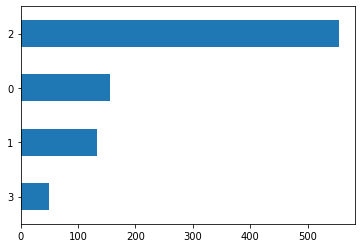

In [14]:
train.label.value_counts(ascending=True).plot.barh()
plt.show()

 As you can see the distribution of our classes are rather unbalanced

# Tokenize

In [15]:
from transformers import AutoTokenizer

model_ckpt = 'distilbert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [16]:
### for inspecting the vocabulary size
print('tokenizer vocab size:', tokenizer.vocab_size)

### model maximum context size
print('model max length:', tokenizer.model_max_length)

### feature name - An attribute to know about is the name of the fields that the model expects in its forward pass
print('Feature names:', tokenizer.model_input_names)

tokenizer vocab size: 30522
model max length: 512
Feature names: ['input_ids', 'attention_mask']


In [17]:
def tokenize(batch):
  return tokenizer(batch['verse_text'],padding=True,truncation=True)

In [20]:
print(tokenize(ds_orignal_from_hf['train'][:2]))

{'input_ids': [[101, 2007, 5122, 2630, 22681, 1012, 1999, 2122, 9379, 13178, 1011, 1011, 102], [101, 2009, 6223, 2061, 2146, 2004, 4212, 1996, 4542, 1010, 102, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]]}


In [24]:
ds_pretrained_features_encoded = ds_orignal_from_hf.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

By doing **"batched=True"** will encode the text in batches, because we've set **"batch_size = None"** our tokenize function will be applied on the full dataset as a single batch.
This ensures the the input tensor and the attention mask have the same shape globally.

In [25]:
print('feature names of dataset', ds_pretrained_features_encoded['train'].column_names)

feature names of dataset ['id', 'verse_text', 'label', 'input_ids', 'attention_mask']


# Training a text classifier - DistilBERT

### Token Encoding > Token Embedding > Encoder Stack > Hidden States > Classification head > Predictions

## Using Pretraiend Model - distilBERT

In [32]:
from transformers import AutoModel

model_ckpt = 'distilbert-base-uncased'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
def get_hidden_state(batch):
  inputs = {k:v.to(device) for k, v in batch.items()
                if k in tokenizer.model_input_names }

  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state

    return {'hidden_state': last_hidden_state[:,0].cpu().numpy() }

ds_pretrained_features_encoded.set_format('torch',columns=['label', 'input_ids', 'attention_mask'])

pretrained_hidden_states = ds_pretrained_features_encoded.map(get_hidden_state, batched=True)

pretrained_hidden_states['train'].column_names

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

['id', 'verse_text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [34]:
pretrained_hidden_states

DatasetDict({
    train: Dataset({
        features: ['id', 'verse_text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 892
    })
    validation: Dataset({
        features: ['id', 'verse_text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 105
    })
    test: Dataset({
        features: ['id', 'verse_text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 104
    })
})

In [37]:
X_train = np.array(pretrained_hidden_states['train']['hidden_state'])
X_valid = np.array(pretrained_hidden_states['validation']['hidden_state'])

y_train = np.array(pretrained_hidden_states['train']['label'])
y_valid = np.array(pretrained_hidden_states['validation']['label'])

In [38]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 4.3 MB/s 
     |████████████████████████████████| 1.1 MB 22.3 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=456818cad044b75d31d5ba64d5dd10c43c3b45e0087b6477b004ccadddff7e3f
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=7d0ee68f8eb516270fc310e65289418643609ac164524be4d500dc7b76793dfb
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [41]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

X_train_scaled = MinMaxScaler().fit_transform(X_train)

mapper = UMAP(n_components = 2, metric='cosine').fit(X_train_scaled)

df_embedded_from_hidden = pd.DataFrame(mapper.embedding_,columns=['X','Y'])

df_embedded_from_hidden['label'] = y_train

display(df_embedded_from_hidden.head())

,X,Y,label
0,13.340225,7.092544,1
1,9.353611,7.101732,2
2,10.936194,4.746432,0
3,8.712949,6.989944,3
4,11.947337,6.353735,3


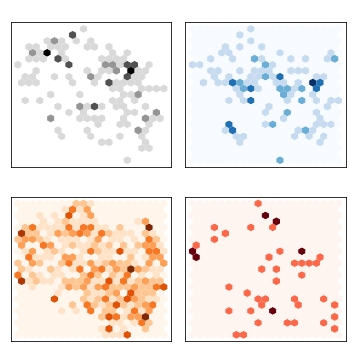

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(5,5))

axes = axes.flatten()


cmaps = ['Greys', 'Blues', 'Oranges', 'Reds', 'Purples', 'Greens']

labels = ds_orignal_from_hf['train'].features['label'].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_embedding_subplot = df_embedded_from_hidden.query(f'label == {i}')
  axes[i].hexbin(df_embedding_subplot['X'], df_embedding_subplot['Y'],
                 cmap=cmap, gridsize = 20, linewidth=(0,))
  axes[i].set_title(label, color='white')
  axes[i].set_xticks([])
  axes[i].set_yticks([])

plt.tight_layout()
plt.show()

## Training a simple Logistic Classifier

In [46]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train,y_train)
print('Logistic Regression Score', lr_clf.score(X_valid,y_valid))

Logistic Regression Score 0.780952380952381


## Dummy Classifier

Our orignal dataset was quite unbalanced, so the logistic regression score is not too good.

So we're just going to compare by doing a random Logistic regression by creating a dummy classifier.

In Scikit Learn there is a dummy classifier that can be used to build a classifier with simple heuristics such as always choosing the majority classs or always drawing a random class.

In this case the best performing heurestic is to choose the most frequently occuring class

In [48]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent')

dummy_clf.fit(X_train,y_train)

print(dummy_clf.score(X_valid,y_valid))

0.6571428571428571


## Fine Tuning DistilBERT

In [58]:
from transformers import AutoModelForSequenceClassification

num_labels = len(ds_orignal_from_hf['train'].features['label'].names)

model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

from sklearn.metrics import accuracy_score, f1_score

def compute_metric(pred):
  labels = pred.label_ids
  pred = pred.predictions.argmax(-1)
  f1 = f1_score(labels, pred, average = 'weighted')

  acc = accuracy_score(labels,pred)

  return {'accuracy': acc, 'fi_score': f1}

## Training

In [59]:
from transformers import Trainer, TrainingArguments

batch_size = 12
logging_steps = len(ds_pretrained_features_encoded['train']) // batch_size

model_name = f"{model_ckpt}.finetune-poem"

training_args = TrainingArguments(output_dir = model_name, 
                                  num_train_epochs=5,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, 
                                  log_level="error"
                                  )

In [60]:
trainer = Trainer(model=model, args=training_args, compute_metrics = compute_metric,
                  train_dataset = ds_pretrained_features_encoded['train'],
                  eval_dataset = ds_pretrained_features_encoded['validation'],
                  tokenizer = tokenizer
                )

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Fi Score
1,1.010900,0.786572,0.657143,0.521182
2,0.711100,0.536636,0.838095,0.827681
3,0.461800,0.570897,0.838095,0.821387
4,0.296400,0.450265,0.885714,0.873095
5,0.239200,0.403400,0.876190,0.866088


TrainOutput(global_step=375, training_loss=0.5398813613255818, metrics={'train_runtime': 846.0884, 'train_samples_per_second': 5.271, 'train_steps_per_second': 0.443, 'total_flos': 32310778846080.0, 'train_loss': 0.5398813613255818, 'epoch': 5.0})

In [61]:
preds_output = trainer.predict(ds_pretrained_features_encoded['validation'])



In [62]:
preds_output.metrics

{'test_loss': 0.4034000635147095,
 'test_accuracy': 0.8761904761904762,
 'test_fi_score': 0.8660882134773761,
 'test_runtime': 12.7176,
 'test_samples_per_second': 8.256,
 'test_steps_per_second': 0.708}

## Error Analysis - detect wron labels by putting the actual and predicted side by side

In [77]:
from torch.nn.functional import cross_entropy

def forward_pass_with_loss_and_label(batch):
  inputs = {k: v.to(device) for k, v in batch.items() 
              if k in tokenizer.model_input_names}

  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis = -1)
    loss = cross_entropy(output.logits, batch['label'].to(device), reduction='none')

  return {'loss': loss.cpu().numpy(), 'predicted_label': pred_label.cpu().numpy() }

In [78]:
## hide_output
## Convert our dataset back to pytorch tensors
ds_pretrained_features_encoded.set_format('torch',columns=['label', 'input_ids', 'attention_mask'])

## Compare loss values
ds_pretrained_features_encoded['validation'] = ds_pretrained_features_encoded['validation'] .map(forward_pass_with_loss_and_label,
                                                                                     batched=True, batch_size=16)

  0%|          | 0/7 [00:00<?, ?ba/s]

In [80]:
def label_int2str(row):
    return ds_orignal_from_hf['train'].features['label'].int2str(row)

ds_pretrained_features_encoded.set_format("pandas")

cols = ['verse_text', "label", "predicted_label", "loss"]

df_test = ds_pretrained_features_encoded["validation"][:][cols]

df_test["label"] = df_test["label"].apply(label_int2str)

df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

df_test.sort_values('loss', ascending=False ).head(10)

,verse_text,label,predicted_label,loss
63,on us lift up the light,positive,no_impact,5.109768
6,"taking and giving radiance, and the slopes",positive,no_impact,4.978419
66,i kin eat in peace.,positive,no_impact,4.678273
80,strong tarchon snatch’d and bore away his prize.,positive,negative,3.445800
73,willis sneered:,negative,no_impact,3.327991
52,"nor can express the love it knew,",negative,positive,2.598417
22,"let fall on her a rose-leaf rain of dreams,",positive,no_impact,2.105510
97,with the freedom of lakes and lands.,positive,no_impact,1.644685
41,alone went the fair-armed gudrun to her flower...,positive,no_impact,1.518027
1,"shall yet be glad for him, and he shall bless",positive,no_impact,1.397548


In [81]:
df_test.sort_values('loss', ascending=True ).head(10)

,verse_text,label,predicted_label,loss
45,"and i greet from far the ray,",no_impact,no_impact,0.016051
49,"no, truly.--i will see her; tell my tale,",no_impact,no_impact,0.016213
39,"soon ez she gits out o' sight,",no_impact,no_impact,0.016257
15,from his lady's white hand caught;,no_impact,no_impact,0.016288
74,"from the bed of minnehaha,",no_impact,no_impact,0.016418
94,"his bark her anchor weighed,",no_impact,no_impact,0.016470
54,"might, looking up, see dian dip",no_impact,no_impact,0.016631
37,"why write i still all one, ever the same,",no_impact,no_impact,0.016641
81,"under the self-same bough, and heard as there",no_impact,no_impact,0.016705
43,"breathe deep, and start, to see him pass the d...",no_impact,no_impact,0.016789
